In [1]:
from tensorflow.keras.callbacks import Callback
import pandas as pd
import random 
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib.pylab import mpl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import LeakyReLU,Conv1D,Dense
from tcn import TCN,tcn_full_summary
from sklearn.metrics import mean_squared_error # 均方误差
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input,Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
my_seed = 666
np.random.seed(my_seed)
random.seed(my_seed)
tf.random.set_seed(my_seed)

In [3]:
female_train_vidio_path = 'H:/data/vidio_data/female_train_D_feature/female_train_D_vidio.csv'
female_dev_vidio_path = 'H:/dev_data/vidio_data/female_dev_D_feature/female_dev_D_vidio.csv'
female_dev_vidio_path2 = 'H:/dev_data/vidio_data/female_dev_ND_feature/female_dev_ND_vidio.csv'
female_train_vidio_path2 = 'H:/data/vidio_data/female_train_ND_feature/female_train_ND_vidio.csv'

male_train_vidio_path = 'H:/data/vidio_data/male_train_D_feature/male_train_D_vidio.csv'
male_dev_vidio_path = 'H:/dev_data/vidio_data/male_dev_D_feature/male_dev_D_vidio.csv'
male_dev_vidio_path2 = 'H:/dev_data/vidio_data/male_dev_ND_feature/male_dev_ND_vidio.csv'
male_train_vidio_path2 = 'H:/data/vidio_data/male_train_ND_feature/male_train_ND_vidio.csv'

df1 = pd.read_csv(female_train_vidio_path,index_col=0)
df2 = pd.read_csv(female_dev_vidio_path,index_col=0)
df3 = pd.read_csv(female_dev_vidio_path2,index_col=0)
df4 = pd.read_csv(female_train_vidio_path2,index_col=0)

df5 = pd.read_csv(male_train_vidio_path,index_col=0)
df6 = pd.read_csv(male_dev_vidio_path,index_col=0)
df7 = pd.read_csv(male_dev_vidio_path2,index_col=0)
df8 = pd.read_csv(male_train_vidio_path2,index_col=0)

df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8],ignore_index=True)
df = df.sample(frac=1.0).reset_index(drop=True)

In [4]:
len1 = int(df.shape[0]*0.9)
train=df[:len1]
test=df[len1:]

#不对y进行归一化
X_train=train.iloc[:,:-1]
Y_train=train.iloc[:,-1:]
X_test=test.iloc[:,:-1]
Y_test=test.iloc[:,-1:]

In [5]:
# 标准化
# scaler = StandardScaler().fit(X_Train)
# X_train = pd.DataFrame(scaler.transform(X_Train))
# X_test = pd.DataFrame(scaler.transform(X_Test))
# #归一化
df = df.iloc[:,:-1]
scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
X_train=pd.DataFrame(scaler.fit_transform(X_train))
X_test=pd.DataFrame(scaler.transform(X_test))

In [6]:
Y_test = Y_test.reset_index(drop=True)
Y_test.head(10)

,4080
0,0.0
1,10.0
2,3.0
3,3.0
4,16.0
5,9.0
6,12.0
7,11.0
8,18.0
9,7.0


In [7]:
vidio_dev = pd.concat([X_test,Y_test],ignore_index=True,axis=1)
# vidio_dev.to_csv("vidio_dev.csv")

In [8]:
x_train=X_train.values.reshape([X_train.shape[0],1,X_train.shape[1]]) 
y_train=Y_train.values
x_test=X_test.values.reshape([X_test.shape[0],1,X_test.shape[1]])  
y_test=Y_test.values

In [9]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((520, 1, 4080), (520, 1), (58, 1, 4080), (58, 1))

In [10]:
def rmse(y_pred, y_true):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [11]:
batch_size=None
timesteps=x_train.shape[1]
input_dim=x_train.shape[2] #输入维数
tcn = Sequential()
input_layer =Input(batch_shape=(batch_size,timesteps,input_dim))
tcn.add(input_layer)
tcn.add(TCN(nb_filters=32, #在卷积层中使用的过滤器数。可以是列表。
        kernel_size=2, #在每个卷积层中使用的内核大小。
        nb_stacks=1,   #要使用的残差块的堆栈数。
        dilations=[2 ** i for i in range(4)], #扩张列表。示例为：[1、2、4、8、16、32、64]。
        #用于卷积层中的填充,值为'causal' 或'same'。
        #“causal”将产生因果（膨胀的）卷积，即output[t]不依赖于input[t+1：]。当对不能违反时间顺序的时序信号建模时有用。
        #“same”代表保留边界处的卷积结果，通常会导致输出shape与输入shape相同。
        padding='causal',
        use_skip_connections=True, #是否要添加从输入到每个残差块的跳过连接。
        dropout_rate=0.3, #在0到1之间浮动。要下降的输入单位的分数。
        return_sequences=False,#是返回输出序列中的最后一个输出还是完整序列。
        activation='relu', #残差块中使用的激活函数 o = Activation(x + F(x)).
        kernel_initializer='he_normal', #内核权重矩阵（Conv1D）的初始化程序。
        use_batch_norm=True, #是否在残差层中使用批处理规范化。
#         use_layer_norm=False, #是否在残差层中使用层归一化。
        name='tcn' #使用多个TCN时，要使用唯一的名称
        ))
tcn.add(tf.keras.layers.Dense(1))
tcn.compile('adam', loss=rmse, metrics=['mae'])
tcn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 32)                407328    
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 407,361
Trainable params: 406,849
Non-trainable params: 512
_________________________________________________________________


In [12]:
early_stopping = EarlyStopping(monitor='val_mae', patience=10, verbose=2)
checkpoint = ModelCheckpoint('vidio_1.h5', monitor='val_mae', verbose=1,save_best_only=True,mode='min',period=2)
callbacks_list=[checkpoint,early_stopping]
history=tcn.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=128,callbacks=[callbacks_list])

Epoch 1/100
5/5 [==============================] - 0s 67ms/step - loss: 11.3265 - mae: 9.6154 - val_loss: 14.6437 - val_mae: 13.2289
Epoch 2/100
1/5 [=====>........................] - ETA: 0s - loss: 11.5539 - mae: 9.7801
Epoch 00002: val_mae improved from inf to 14.21933, saving model to vidio_1.h5
5/5 [==============================] - 0s 22ms/step - loss: 11.0228 - mae: 9.3020 - val_loss: 15.5396 - val_mae: 14.2193
Epoch 3/100
5/5 [==============================] - 0s 10ms/step - loss: 10.7686 - mae: 9.0284 - val_loss: 15.6314 - val_mae: 14.3308
Epoch 4/100
1/5 [=====>........................] - ETA: 0s - loss: 10.1065 - mae: 8.4361
Epoch 00004: val_mae improved from 14.21933 to 13.65273, saving model to vidio_1.h5
5/5 [==============================] - 0s 22ms/step - loss: 10.4629 - mae: 8.6933 - val_loss: 14.9911 - val_mae: 13.6527
Epoch 5/100
5/5 [==============================] - 0s 11ms/step - loss: 10.0937 - mae: 8.4094 - val_loss: 14.2933 - val_mae: 12.8828
Epoch 6/100
1/5 [=

Epoch 00040: val_mae did not improve from 6.30904
5/5 [==============================] - 0s 10ms/step - loss: 5.4028 - mae: 4.4682 - val_loss: 7.6113 - val_mae: 6.4435
Epoch 41/100
5/5 [==============================] - 0s 10ms/step - loss: 5.3635 - mae: 4.4797 - val_loss: 7.5778 - val_mae: 6.3929
Epoch 42/100
1/5 [=====>........................] - ETA: 0s - loss: 5.6860 - mae: 4.7439
Epoch 00042: val_mae improved from 6.30904 to 6.20923, saving model to vidio_1.h5
5/5 [==============================] - 0s 21ms/step - loss: 5.4383 - mae: 4.5153 - val_loss: 7.4300 - val_mae: 6.2092
Epoch 43/100
5/5 [==============================] - 0s 12ms/step - loss: 5.4885 - mae: 4.5349 - val_loss: 7.2136 - val_mae: 5.9570
Epoch 44/100
1/5 [=====>........................] - ETA: 0s - loss: 5.9529 - mae: 5.0579
Epoch 00044: val_mae improved from 6.20923 to 5.87882, saving model to vidio_1.h5
5/5 [==============================] - 0s 21ms/step - loss: 5.4962 - mae: 4.5728 - val_loss: 7.0965 - val_mae:

In [13]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

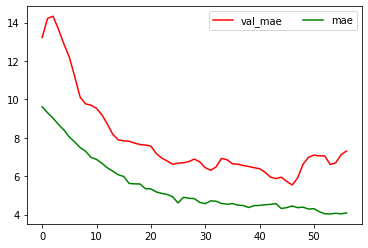

In [14]:
history.history.keys() #查看history中存储了哪些参数
plt.plot(history.epoch,history.history.get('val_mae'),'r',label='val_mae') #画出随着epoch增大loss的变化图
plt.plot(history.epoch,history.history.get('mae'),'g',label='mae')#画出随着epoch增大准确率的变化图
plt.legend(loc=0,ncol=2)

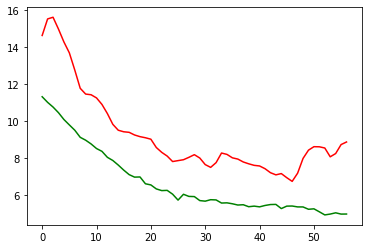

In [15]:
history.history.keys() #查看history中存储了哪些参数
plt.plot(history.epoch,history.history.get('val_loss'),'r',label='val_loss') #画出随着epoch增大loss的变化图
plt.plot(history.epoch,history.history.get('loss'),'g',label='loss')#画出随着epoch增大准确率的变化图

In [16]:
# model_name = 'vidio_1.h5'
# tcn.save(model_name)

In [17]:
score_test = tcn.evaluate(x_test,y_test)
score_test

2/2 [==============================] - 0s 984us/step - loss: 8.8437 - mae: 7.3145


[8.843748092651367, 7.314545631408691]